In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
print(tf.__version__)

2.3.0


In [ ]:
mnist = keras.datasets.mnist
(train_images_mnist,train_labels_mnist),(test_images_mnist,test_labels_mnist) = mnist.load_data()
# images are reshaped to be used by the flow method of a keras ImageGenerator
train_images_mnist = np.reshape(train_images_mnist,(train_images_mnist.shape[0],28,28,1))  
test_images_mnist = np.reshape(test_images_mnist,(test_images_mnist.shape[0],28,28,1))

In [ ]:
AZ_data = pd.read_csv('A_Z Handwritten Data.csv',header = None)
# the first column contains label values, while the remaining are the flattened array of 28 x 28 image pixels
AZ_labels = AZ_data.values[:,0]
AZ_images = AZ_data.values[:,1:]
# images are reshaped to be used by the flow method of a keras ImageGenerator
AZ_images = np.reshape(AZ_images,(AZ_images.shape[0],28,28,1))  

In [ ]:
mnist

In [ ]:
# join datasets
# split AZ data in train and test
from sklearn.model_selection import train_test_split

test_size = float(len(test_labels_mnist))/len(train_labels_mnist)
print(f'test set size: {test_size}')
train_images_AZ, test_images_AZ, train_labels_AZ, test_labels_AZ = train_test_split(AZ_images,AZ_labels, test_size=test_size)
#shift mnist labels 
train_labels_mnist = train_labels_mnist + max(AZ_labels)+1
test_labels_mnist = test_labels_mnist + max(AZ_labels)+1

# concatenate datasets
train_images = np.concatenate((train_images_AZ,train_images_mnist),axis=0)
train_labels = np.concatenate((train_labels_AZ,train_labels_mnist))
test_images = np.concatenate((test_images_AZ,test_images_mnist),axis=0)
test_labels = np.concatenate((test_labels_AZ,test_labels_mnist))

print('Data ready')

In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(len(np.unique(train_labels)), activation='softmax')  
])

model.compile(optimizer=RMSprop(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

model.summary()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=15,
      width_shift_range=0.1,
      height_shift_range=0.1,
      shear_range=0.1,
      zoom_range=0.2,
      horizontal_flip=False,
      fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Flow training images in batches using generator
train_generator = train_datagen.flow(train_images, train_labels, batch_size=50, shuffle=True)
validation_generator = test_datagen.flow(test_images, test_labels, batch_size=50, shuffle=True)

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=500,  
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,  
      verbose=2)
model.save('model_v2')

In [2]:
from tensorflow.keras.models import load_model
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

import imutils
from imutils.contours import sort_contours

In [3]:
# loads the model with the keras load_model function
model_path = 'model_v2'
print("Loading NN model...")
model = load_model(model_path)
print("Done")

Loading NN model...
Done


In [4]:
# loads the input image
image_path = 'misc.jpg'
image = cv2.imread(image_path)
#from google.colab import files
#image = files.upload() 

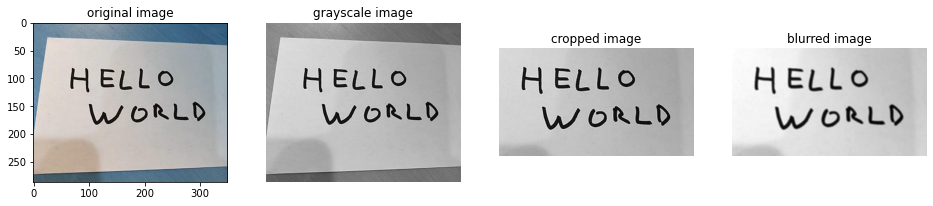

In [5]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
cropped = gray[50:-60,30:-2]
blurred = cv2.GaussianBlur(cropped, (5, 5), 0)


%matplotlib inline
from matplotlib import cm
fig = plt.figure(figsize=(16,4))
ax = plt.subplot(1,4,1)
ax.imshow(image)
ax.set_title('original image');

ax = plt.subplot(1,4,2)
ax.imshow(gray,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('grayscale image');

ax = plt.subplot(1,4,3)
ax.imshow(cropped,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('cropped image');

ax = plt.subplot(1,4,4)
ax.imshow(blurred,cmap=cm.binary_r)
ax.set_axis_off()
ax.set_title('blurred image');
#plt.imshow(gray,cmap=cm.binary_r)

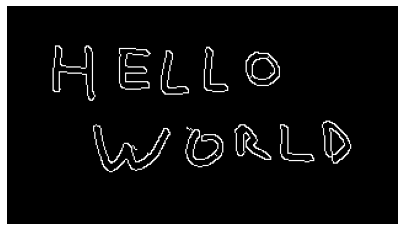

In [12]:
# perform edge detection, find contours in the edge map, and sort the
# resulting contours from left-to-right
edged = cv2.Canny(cropped, 30, 250) #low_threshold, high_threshold
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="left-to-right")[0]

figure = plt.figure(figsize=(7,7))
plt.axis('off');
plt.imshow(edged,cmap=cm.binary_r);

In [13]:
chars = []
# loop over the contours
for c in cnts:
	# compute the bounding box of the contour and isolate ROI
  (x, y, w, h) = cv2.boundingRect(c)
  roi = cropped[y:y + h, x:x + w]
  
  #binarize image, finds threshold with OTSU method
  thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
  
  # resize largest dimension to input size
  (tH, tW) = thresh.shape
  if tW > tH:
    thresh = imutils.resize(thresh, width=28)
  # otherwise, resize along the height
  else:
    thresh = imutils.resize(thresh, height=28)

  # find how much is needed to pad
  (tH, tW) = thresh.shape
  dX = int(max(0, 28 - tW) / 2.0)
  dY = int(max(0, 28 - tH) / 2.0)
  # pad the image and force 28 x 28 dimensions
  padded = cv2.copyMakeBorder(thresh, top=dY, bottom=dY,
    left=dX, right=dX, borderType=cv2.BORDER_CONSTANT,
    value=(0, 0, 0))
  padded = cv2.resize(padded, (28, 28))
  # reshape and rescale padded image for the model
  padded = padded.astype("float32") / 255.0
  padded = np.expand_dims(padded, axis=-1)
  # append image and bounding box data in char list
  chars.append((padded, (x, y, w, h)))

<ipython-input-14-3e2319900081>:6: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = plt.subplot(n_rows,n_cols,i+1)


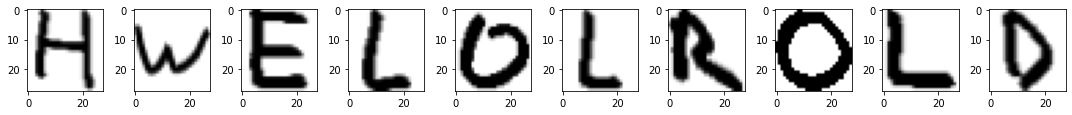

In [14]:
# plot isolated characters
n_cols = 10
n_rows = np.floor(len(chars)/ n_cols)+1
fig = plt.figure(figsize=(1.5*n_cols,1.5*n_rows))
for i,char in enumerate(chars):
  ax = plt.subplot(n_rows,n_cols,i+1)
  ax.imshow(char[0][:,:,0],cmap=cm.binary,aspect='auto')
  #plt.axis('off')
plt.tight_layout()

In [15]:
boxes = [b[1] for b in chars]
chars = np.array([c[0] for c in chars], dtype="float32")
# OCR the characters using our handwriting recognition model
preds = model.predict(chars)
# define the list of label names
labelNames = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"

In [16]:
boxes

[(37, 32, 35, 45),
 (70, 96, 63, 39),
 (91, 34, 26, 34),
 (125, 36, 23, 36),
 (145, 98, 31, 33),
 (160, 33, 20, 37),
 (185, 96, 30, 29),
 (194, 37, 28, 28),
 (222, 96, 28, 31),
 (256, 93, 24, 35)]

In [17]:
chars

array([[[[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        ...,

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]],

        [[0.        ],
         [0.        ],
         [0.        ],
         ...,
         [0.        ],
         [0.        ],
         [0.        ]]],


       [[[0.        ],
         [0.        ],
         [0.  

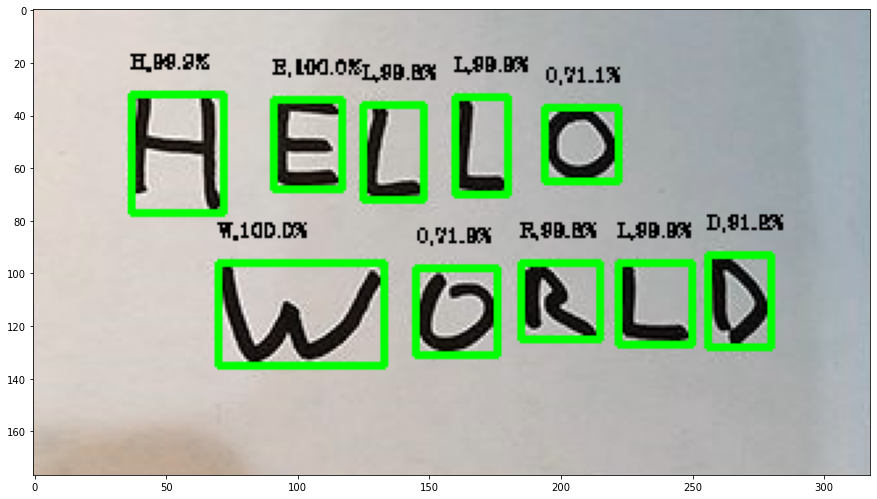

In [37]:
image = cv2.imread(image_path)
cropped = image[50:-60,30:-2]

for (pred, (x, y, w, h)) in zip(preds, boxes):
	# find the index of the label with the largest corresponding
	# probability, then extract the probability and label
  i = np.argmax(pred)
  prob = pred[i]
  label = labelNames[i]
  # draw the prediction on the image and it's probability
  label_text = f"{label},{prob * 100:.1f}%"
  cv2.rectangle(cropped, (x, y), (x + w, y + h), (0,255 , 0), 2)
    
  cv2.putText(cropped, label_text, (x , y -10),cv2.FONT_HERSHEY_COMPLEX,0.23, (0,0, 0), 1)

# show the image
plt.figure(figsize=(15,10))
plt.imshow(cropped)